In [29]:
import pandas as pd

In [30]:
df = pd.read_csv('/content/synthetic_personal_finance_dataset.csv')
df.head()

,user_id,age,gender,education_level,employment_status,job_title,monthly_income_usd,monthly_expenses_usd,savings_usd,has_loan,loan_type,loan_amount_usd,loan_term_months,monthly_emi_usd,loan_interest_rate_pct,debt_to_income_ratio,credit_score,savings_to_income_ratio,region,record_date
0,U00001,56,Female,High School,Self-employed,Salesperson,3531.69,1182.59,367655.03,No,NaN,0.00,0,0.00,0.00,0.00,430,8.68,Other,2024-01-09
1,U00002,19,Female,PhD,Employed,Salesperson,3531.73,2367.99,260869.10,Yes,Education,146323.34,36,4953.50,13.33,1.40,543,6.16,North America,2022-02-13
2,U00003,20,Female,Master,Employed,Teacher,2799.49,1003.91,230921.21,No,NaN,0.00,0,0.00,0.00,0.00,754,6.87,Africa,2022-05-12
3,U00004,25,Male,PhD,Employed,Manager,5894.88,4440.12,304815.51,Yes,Business,93242.37,24,4926.57,23.93,0.84,461,4.31,Europe,2023-10-02
4,U00005,53,Female,PhD,Employed,Student,5128.93,4137.61,461509.48,No,NaN,0.00,0,0.00,0.00,0.00,516,7.50,Africa,2021-08-07


In [31]:
df['user_id'].duplicated().any() # One row per user, no time-series

np.False_

In [32]:
df.columns

Index(['user_id', 'age', 'gender', 'education_level', 'employment_status',
       'job_title', 'monthly_income_usd', 'monthly_expenses_usd',
       'savings_usd', 'has_loan', 'loan_type', 'loan_amount_usd',
       'loan_term_months', 'monthly_emi_usd', 'loan_interest_rate_pct',
       'debt_to_income_ratio', 'credit_score', 'savings_to_income_ratio',
       'region', 'record_date'],
      dtype='object')

## Select Relevant Columns

In [33]:
df = df[['user_id', 'monthly_income_usd', 'monthly_expenses_usd',
         'savings_usd', 'monthly_emi_usd', 'record_date']]

## Sort & Prepare Time Series




In [34]:
df['record_date'] = pd.to_datetime(df['record_date'])
df = df.sort_values(['record_date'])

## Compute Net Cash Flow

In [35]:
# net_cashflow → income minus expenses
df['net_cashflow'] = df['monthly_income_usd'] - (df['monthly_expenses_usd'] + df['monthly_emi_usd'])

## Create classification target
1 = high risk (negative cashflow) \
0 = safe

In [36]:
df['cashflow_risk'] = (df['net_cashflow'] < 0).astype(int)
df.head()

,user_id,monthly_income_usd,monthly_expenses_usd,savings_usd,monthly_emi_usd,record_date,net_cashflow,cashflow_risk
17754,U17755,3803.68,1741.06,180584.35,0.00,2021-07-23,2062.62,0
5341,U05342,5995.97,3830.74,134408.75,0.00,2021-07-23,2165.23,0
6808,U06809,3049.39,1813.14,290617.58,4685.05,2021-07-23,-3448.80,1
29985,U29986,6407.64,4852.40,627997.42,0.00,2021-07-23,1555.24,0
22755,U22756,8229.98,5560.88,71171.93,0.00,2021-07-23,2669.10,0


In [37]:
df.describe()

,monthly_income_usd,monthly_expenses_usd,savings_usd,monthly_emi_usd,record_date,net_cashflow,cashflow_risk
count,32424.000000,32424.000000,3.242400e+04,32424.000000,32424,32424.000000,32424.000000
mean,4027.863185,2419.444709,2.437520e+05,3092.992339,2023-07-24 02:38:14.300518400,-1484.573863,0.330743
min,500.000000,150.010000,6.359600e+02,0.000000,2021-07-23 00:00:00,-46671.120000,0.000000
25%,2657.795000,1397.497500,8.629155e+04,0.000000,2022-07-22 00:00:00,-2009.057500,0.000000
50%,3997.740000,2219.575000,2.017003e+05,0.000000,2023-07-24 00:00:00,720.750000,0.000000
75%,5351.607500,3254.037500,3.589662e+05,3574.567500,2024-07-22 00:00:00,1728.392500,1.000000
max,12404.050000,10082.710000,1.237774e+06,47723.840000,2025-07-22 00:00:00,7097.560000,1.000000
std,1916.773353,1388.893084,1.915772e+05,6478.939776,NaN,6571.508431,0.470488


## Select features (common to both models)

In [38]:
features = [
    'monthly_income_usd',
    'monthly_expenses_usd',
    'monthly_emi_usd',
    'savings_usd'
]

# MODEL 1 — XGBoost CLASSIFICATION
Predict risk of negative cashflow

In [39]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[features]
y = df['cashflow_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = XGBClassifier(
    eval_metric='logloss'
)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4293
           1       0.99      0.99      0.99      2192

    accuracy                           0.99      6485
   macro avg       0.99      0.99      0.99      6485
weighted avg       0.99      0.99      0.99      6485



# MODEL 2 — XGBoost REGRESSION
Predict expected cashflow

In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

X = df[features]
y = df['net_cashflow']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg = XGBRegressor()
reg.fit(X_train, y_train)

pred = reg.predict(X_test)
print("MAE:", mean_absolute_error(y_test, pred))


MAE: 89.95854877532659


# Feature Engineering

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Ratios
df['expenses_to_income'] = df['monthly_expenses_usd'] / df['monthly_income_usd']
df['savings_to_income'] = df['savings_usd'] / df['monthly_income_usd']


# Update features list
features = features + ['expenses_to_income', 'savings_to_income']

# Train/Test Split

In [42]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['net_cashflow']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Hyperparameter-Tuned XGBRegressor

* n_estimators → more trees for better fit.
* max_depth → controls tree complexity.
* learning_rate → smaller → more stable learning.
* subsample / colsample_bytree → regularization, reduce overfitting.

In [43]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

reg = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

reg.fit(X_train, y_train)

pred = reg.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print("MAE:", mae)
print("R² score:", r2)

MAE: 59.226046837445665
R² score: 0.9996647525047055


# Visual Evaluation

*   Red dashed line → perfect prediction.
*   Points close to the line → good predictions.







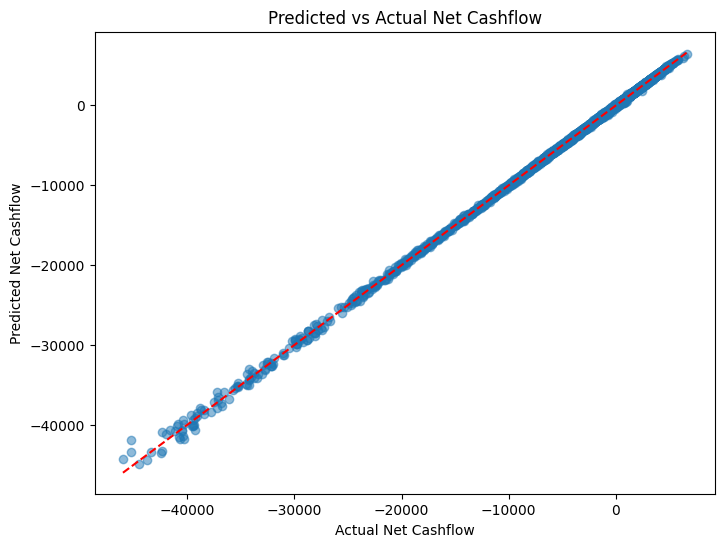

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Net Cashflow')
plt.ylabel('Predicted Net Cashflow')
plt.title('Predicted vs Actual Net Cashflow')
plt.show()

# Teeeeeest

In [45]:
import pandas as pd

low_risk = pd.DataFrame({
    'monthly_income_usd': [5000],
    'monthly_expenses_usd': [3000],
    'monthly_emi_usd': [200],
    'savings_usd': [2000],
    'expenses_to_income': [3000/5000],
    'savings_to_income': [2000/5000]
})

low_risk = low_risk[features]
pred_low = reg.predict(low_risk)
print("Low-Risk Predicted Net Cashflow:", pred_low[0])

Low-Risk Predicted Net Cashflow: 1788.8782


In [46]:
medium_risk = pd.DataFrame({
    'monthly_income_usd': [3000],
    'monthly_expenses_usd': [2500],
    'monthly_emi_usd': [300],
    'savings_usd': [500],
    'expenses_to_income': [2500/3000],
    'savings_to_income': [500/3000]
})

medium_risk = medium_risk[features]
pred_medium = reg.predict(medium_risk)
print("Medium-Risk Predicted Net Cashflow:", pred_medium[0])

Medium-Risk Predicted Net Cashflow: 179.74362


In [47]:
high_risk = pd.DataFrame({
    'monthly_income_usd': [1500],
    'monthly_expenses_usd': [1800],
    'monthly_emi_usd': [400],
    'savings_usd': [100],
    'expenses_to_income': [1800/1500],
    'savings_to_income': [100/1500]
})

high_risk = high_risk[features]
pred_high = reg.predict(high_risk)
print("High-Risk Predicted Net Cashflow:", pred_high[0])

High-Risk Predicted Net Cashflow: -330.18463


In [48]:
extreme_risk = pd.DataFrame({
    'monthly_income_usd': [1000],
    'monthly_expenses_usd': [2000],
    'monthly_emi_usd': [600],
    'savings_usd': [50],
    'expenses_to_income': [2000/1000],
    'savings_to_income': [50/1000]
})

extreme_risk = extreme_risk[features]
pred_extreme = reg.predict(extreme_risk)
print("Extreme-Risk Predicted Net Cashflow:", pred_extreme[0])

Extreme-Risk Predicted Net Cashflow: -609.7601


# Save Trained models

In [49]:
import joblib
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
import pandas as pd

# Create directory for trained models
os.makedirs('trained_models', exist_ok=True)

# Your existing feature engineering and data preparation
df['expenses_to_income'] = df['monthly_expenses_usd'] / df['monthly_income_usd']
df['savings_to_income'] = df['savings_usd'] / df['monthly_income_usd']

features = [
    'monthly_income_usd',
    'monthly_expenses_usd',
    'monthly_emi_usd',
    'savings_usd',
    'expenses_to_income',
    'savings_to_income'
]

# Prepare data for both models
X = df[features]
y_classification = df['cashflow_risk']
y_regression = df['net_cashflow']

X_train, X_test, y_train_clf, y_test_clf = train_test_split(
    X, y_classification, test_size=0.2, random_state=42
)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print("Training and saving models...")

# 1. Train and Save CLASSIFIER
print("Training Classifier...")
clf = XGBClassifier(eval_metric='logloss')
clf.fit(X_train, y_train_clf)

# Evaluate classifier
pred_clf = clf.predict(X_test)
print("Classifier Performance:")
print(classification_report(y_test_clf, pred_clf))

# Save classifier
clf.save_model('trained_models/xgboost_classifier.model')
print("✅ Classifier saved as 'trained_models/xgboost_classifier.pkl'")

# 2. Train and Save REGRESSOR
print("\nTraining Regressor...")
reg = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
reg.fit(X_train_reg, y_train_reg)

# Evaluate regressor
pred_reg = reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, pred_reg)
r2 = r2_score(y_test_reg, pred_reg)
print(f"Regressor Performance:")
print(f"MAE: {mae}")
print(f"R² score: {r2}")

# Save regressor
# Save models using XGBoost's native method
reg.save_model('trained_models/xgboost_regressor.model')
print("✅ Regressor saved as 'trained_models/xgboost_regressor.pkl'")

# 3. Save feature names for reference (important for preprocessing)
feature_info = {
    'feature_names': features,
    'feature_order': features  # Ensure same order during prediction
}
joblib.dump(feature_info, 'trained_models/feature_info.pkl')
print("✅ Feature info saved as 'trained_models/feature_info.pkl'")

print("\n🎉 All models saved successfully!")
print("You can now use these in your FastAPI service.")

Training and saving models...
Training Classifier...
Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4293
           1       0.99      0.99      0.99      2192

    accuracy                           1.00      6485
   macro avg       1.00      1.00      1.00      6485
weighted avg       1.00      1.00      1.00      6485

✅ Classifier saved as 'trained_models/xgboost_classifier.pkl'

Training Regressor...


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1116: UserWarning: [09:03:37] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  self.get_booster().save_model(fname)


Regressor Performance:
MAE: 59.226046837445665
R² score: 0.9996647525047055
✅ Regressor saved as 'trained_models/xgboost_regressor.pkl'
✅ Feature info saved as 'trained_models/feature_info.pkl'

🎉 All models saved successfully!
You can now use these in your FastAPI service.


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1116: UserWarning: [09:03:38] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  self.get_booster().save_model(fname)


# LightGBM

In [53]:
# Add this to your notebook
import lightgbm as lgb
import joblib
import os

print("🔄 Training LightGBM models...")

# Create directory
os.makedirs('trained_models', exist_ok=True)

# Train LightGBM classifier
lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
lgb_clf.fit(X_train, y_train_clf)

# Train LightGBM regressor
lgb_reg = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
lgb_reg.fit(X_train_reg, y_train_reg)

# Save models
joblib.dump(lgb_clf, 'trained_models/lightgbm_classifier.pkl')
joblib.dump(lgb_reg, 'trained_models/lightgbm_regressor.pkl')

# Save feature info
feature_info = {'feature_names': features}
joblib.dump(feature_info, 'trained_models/feature_info.pkl')

# Also save as native LightGBM format (backup)
lgb_clf.booster_.save_model('trained_models/lightgbm_classifier.txt')
lgb_reg.booster_.save_model('trained_models/lightgbm_regressor.txt')

print("✅ LightGBM models saved successfully!")

# Test the models
test_input = {
    'monthly_income_usd': 4000.0,
    'monthly_expenses_usd': 2500.0,
    'monthly_emi_usd': 500.0,
    'savings_usd': 15000.0
}

test_df = pd.DataFrame([test_input])
test_df['expenses_to_income'] = test_df['monthly_expenses_usd'] / test_df['monthly_income_usd']
test_df['savings_to_income'] = test_df['savings_usd'] / test_df['monthly_income_usd']
test_features = test_df[features]

net_cashflow = lgb_reg.predict(test_features)[0]
risk = lgb_clf.predict(test_features)[0]
risk_proba = lgb_clf.predict_proba(test_features)[0]

print(f"🎯 LightGBM Results:")
print(f"  Net Cashflow: {net_cashflow}")
print(f"  Risk: {risk}")
print(f"  Risk Probability: {risk_proba}")

🔄 Training LightGBM models...
[LightGBM] [Info] Number of positive: 8532, number of negative: 17407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 25939, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328926 -> initscore=-0.713049
[LightGBM] [Info] Start training from score -0.713049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt